# Most Lucrative Industries - Project 11<br>
###CS547 Course Project - Group 7 </br>
###Team member: Haoming Sun, Tianhua Tao, Tingrong Zhang, Zhihao Xu

# Dependencies

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import copy
import random
import os
from functools import partial
from collections import defaultdict
import csv
from itertools import chain
from contextlib import redirect_stdout
from torch.utils.tensorboard import SummaryWriter

# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATASET_DIR = "/content/drive/MyDrive/CS547_Project11_Group_7/dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# try to find and load .pkl format first

try:
  state_2021_df = pd.read_pickle((DATASET_DIR + "/state2021.pkl"))
except FileNotFoundError:
# if .pkl DNE read excel format instead and convert to .pkl
  print("state2021.pkl not found, read excel data instead and construct pkl")
  state_2021_df = pd.read_excel(DATASET_DIR + "/state_M2021_dl.xlsx")
  state_2021_df.to_pickle(DATASET_DIR + "/state2021.pkl")

# keep only those useful features only
state_2021_df = state_2021_df[['AREA_TITLE', 'OCC_TITLE', 'TOT_EMP', 'NAICS_TITLE', 'PCT_TOTAL', 'H_MEAN', 'A_MEAN']]

Preview of state_2021 data

In [ ]:
state_2021_df

,AREA_TITLE,OCC_TITLE,TOT_EMP,NAICS_TITLE,PCT_TOTAL,H_MEAN,A_MEAN
0,Alabama,All Occupations,"1,928,110",Cross-industry,NaN,23.13,"48,110"
1,Alabama,Management Occupations,"96,070",Cross-industry,NaN,51.06,"106,210"
2,Alabama,Chief Executives,690,Cross-industry,NaN,72.24,"150,260"
3,Alabama,General and Operations Managers,"34,370",Cross-industry,NaN,54.50,"113,350"
4,Alabama,Legislators,"1,030",Cross-industry,NaN,*,"28,520"
...,...,...,...,...,...,...,...
37575,Virgin Islands,Industrial Truck and Tractor Operators,80,Cross-industry,NaN,14.62,"30,400"
37576,Virgin Islands,Cleaners of Vehicles and Equipment,50,Cross-industry,NaN,13.48,"28,040"
37577,Virgin Islands,"Laborers and Freight, Stock, and Material Move...",370,Cross-industry,NaN,14.51,"30,180"
37578,Virgin Islands,"Packers and Packagers, Hand",110,Cross-industry,NaN,12.65,"26,320"


# Preprocessing and Visualization 

Not all of the entries are available. According to the state dataset of 2021\
"*" indicates that a wage estimate is not available.\
"**" indicates that an employment estimate is not available\
"#" indicates a wage equal to or greater than \$100.00 per hour or \$208,000 per year.\
Lastly, the column of PCT_TOTAL is completely blank.



---



We can first replace all the '#' with their lower bound since that is pretty much the best we can do and there's nowhere else we can find relative information from.

In [ ]:
state_2021_df[(state_2021_df.H_MEAN == '#') | (state_2021_df.A_MEAN == '#')].count()

AREA_TITLE     147
OCC_TITLE      147
TOT_EMP        147
NAICS_TITLE    147
PCT_TOTAL        0
H_MEAN         147
A_MEAN         147
dtype: int64

In [ ]:
state_2021_df['A_MEAN'].replace('#', 208000, inplace=True)
state_2021_df['H_MEAN'].replace('#', 100, inplace=True)

In [ ]:
state_2021_df[(state_2021_df.H_MEAN == '#') | (state_2021_df.A_MEAN == '#')].count()

AREA_TITLE     0
OCC_TITLE      0
TOT_EMP        0
NAICS_TITLE    0
PCT_TOTAL      0
H_MEAN         0
A_MEAN         0
dtype: int64



---



We can remove the NAICS_TITLE since it is meaningless as all the entries are the same "cross-industry". We also want to remove the PCT_TOTAL column as it is empty and the meaning of it is simple the TOT_EMP divided by the number of All Occupations in that state. For the same reason, we remove the All Occupations rows since they are not exactly an occupation.

In [ ]:
# Drop useless columns
state_2021_df_dropped = state_2021_df[['NAICS_TITLE', 'PCT_TOTAL']]
state_2021_df.drop(columns=['NAICS_TITLE', 'PCT_TOTAL'], inplace=True)

# Take out all the "All Occupation" entries
state_2021_all_occ = state_2021_df[state_2021_df["OCC_TITLE"] == 'All Occupations']
state_2021_df.drop(state_2021_all_occ.index, inplace=True)
state_2021_df

,AREA_TITLE,OCC_TITLE,TOT_EMP,H_MEAN,A_MEAN
1,Alabama,Management Occupations,"96,070",51.06,"106,210"
2,Alabama,Chief Executives,690,72.24,"150,260"
3,Alabama,General and Operations Managers,"34,370",54.50,"113,350"
4,Alabama,Legislators,"1,030",*,"28,520"
5,Alabama,Advertising and Promotions Managers,30,53.01,"110,250"
...,...,...,...,...,...
37575,Virgin Islands,Industrial Truck and Tractor Operators,80,14.62,"30,400"
37576,Virgin Islands,Cleaners of Vehicles and Equipment,50,13.48,"28,040"
37577,Virgin Islands,"Laborers and Freight, Stock, and Material Move...",370,14.51,"30,180"
37578,Virgin Islands,"Packers and Packagers, Hand",110,12.65,"26,320"




---



With the data remained, we can extract some simple statistics and visualizations. But, the NaN values will affect the results so we temporarily drop them. Below is the basic statistics of the data.

In [ ]:
state_2021_df.replace(['**', '*'], np.nan, inplace=True)
state_2021_df[['TOT_EMP', 'H_MEAN', 'A_MEAN']] = state_2021_df[['TOT_EMP', 'H_MEAN', 'A_MEAN']].replace([','], '', regex=True).astype(float)
state_2021_df_visual = state_2021_df.dropna()
state_2021_df_visual.describe(include='all').round(2)

,AREA_TITLE,OCC_TITLE,TOT_EMP,H_MEAN,A_MEAN
count,33295,33295,33295.00,33295.00,33295.00
unique,54,788,NaN,NaN,NaN
top,California,Management Occupations,NaN,NaN,NaN
freq,743,54,NaN,NaN,NaN
mean,NaN,NaN,8268.51,29.84,62076.34
std,NaN,NaN,44252.45,18.91,39339.99
min,NaN,NaN,30.00,8.19,17030.00
25%,NaN,NaN,230.00,18.63,38745.00
50%,NaN,NaN,800.00,24.56,51080.00
75%,NaN,NaN,3140.00,35.06,72925.00


We can create a simple correlation matrix and represent it using a seaborn heat map. We can see that H_MEAN and A_MEAN are pretty much the same data as their correlation is equal to 1. This may indicate that we can simply predict for one of the two labels. Also, TOT_EMP seems to have a negative correlation with both of them.

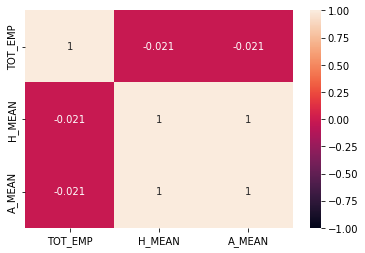

In [ ]:
import seaborn as sns

heatmap = sns.heatmap(state_2021_df_visual.corr(), vmin=-1, vmax=1, annot=True)



---



We can calculate out a column of the work hours of each occupation from the H_MEAN and A_MEAN columns and see if anything is interesting there. We are using state_2021_df_visual because this is the dataframe that dropped NaN values.

In [ ]:
state_2021_df_visual['WORK_HRS'] = state_2021_df_visual['A_MEAN'] / state_2021_df_visual['H_MEAN']
state_2021_df_visual['WORK_HRS'].describe(include='All')

<ipython-input-43-86a123366a3c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_2021_df_visual['WORK_HRS'] = state_2021_df_visual['A_MEAN'] / state_2021_df_visual['H_MEAN']


count    33295.000000
mean      2079.958791
std          0.307700
min       2078.409091
25%       2079.773322
50%       2079.969975
75%       2080.150282
max       2081.395349
Name: WORK_HRS, dtype: float64

We can see that the work hour is constant at about 2080 hours. Thus, we can potentially use this to fill some of the missing data where either of the two is missing in one row entry.

In [ ]:
state_2021_df
for index, row in state_2021_df.iterrows():
    if np.isnan(row['A_MEAN']) & ~np.isnan(row['H_MEAN']):
      state_2021_df.at[index, 'A_MEAN'] = row['H_MEAN'] * 2080
    elif ~np.isnan(row['A_MEAN']) & np.isnan(row['H_MEAN']):
      state_2021_df.at[index, 'H_MEAN'] = row['A_MEAN'] / 2080
    else:
      continue
state_2021_df

,AREA_TITLE,OCC_TITLE,TOT_EMP,H_MEAN,A_MEAN
1,Alabama,Management Occupations,96070.0,51.060000,106210.0
2,Alabama,Chief Executives,690.0,72.240000,150260.0
3,Alabama,General and Operations Managers,34370.0,54.500000,113350.0
4,Alabama,Legislators,1030.0,13.711538,28520.0
5,Alabama,Advertising and Promotions Managers,30.0,53.010000,110250.0
...,...,...,...,...,...
37575,Virgin Islands,Industrial Truck and Tractor Operators,80.0,14.620000,30400.0
37576,Virgin Islands,Cleaners of Vehicles and Equipment,50.0,13.480000,28040.0
37577,Virgin Islands,"Laborers and Freight, Stock, and Material Move...",370.0,14.510000,30180.0
37578,Virgin Islands,"Packers and Packagers, Hand",110.0,12.650000,26320.0


For the rest, we decided to use a KNN Imputer to impute the missing values in the data, which should be better than the traditional way of simply filling them with mean and median values. We don't want to simple drop them either since the size is quite significant. Under this circumstances of this dataset, each occupation is rather unique and impactful to remove.

In [ ]:
state_2021_df[(state_2021_df.H_MEAN.isna()) & (state_2021_df.A_MEAN.isna())].count()

AREA_TITLE    331
OCC_TITLE     331
TOT_EMP       331
H_MEAN          0
A_MEAN          0
dtype: int64

In [ ]:
state_2021_df[(state_2021_df.TOT_EMP.isna())].count()

AREA_TITLE    1241
OCC_TITLE     1241
TOT_EMP          0
H_MEAN        1241
A_MEAN        1241
dtype: int64

We need to first can one-hot encode the AREA_TITLE and OCC_TITLE into numarical values since the KNN Imputer does not take in string values.

In [ ]:
# One Hot Encode
state_2021_df_one_hot = pd.get_dummies(state_2021_df, columns = ['AREA_TITLE', 'OCC_TITLE'])
state_2021_df_one_hot

,TOT_EMP,H_MEAN,A_MEAN,AREA_TITLE_Alabama,AREA_TITLE_Alaska,AREA_TITLE_Arizona,AREA_TITLE_Arkansas,AREA_TITLE_California,AREA_TITLE_Colorado,AREA_TITLE_Connecticut,...,"OCC_TITLE_Weighers, Measurers, Checkers, and Samplers, Recordkeeping","OCC_TITLE_Welders, Cutters, Solderers, and Brazers","OCC_TITLE_Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",OCC_TITLE_Wellhead Pumpers,OCC_TITLE_Wind Turbine Service Technicians,"OCC_TITLE_Woodworkers, All Other","OCC_TITLE_Woodworking Machine Setters, Operators, and Tenders, Except Sawing",OCC_TITLE_Word Processors and Typists,OCC_TITLE_Writers and Authors,OCC_TITLE_Zoologists and Wildlife Biologists
1,96070.0,51.060000,106210.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,690.0,72.240000,150260.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34370.0,54.500000,113350.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1030.0,13.711538,28520.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,30.0,53.010000,110250.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37575,80.0,14.620000,30400.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37576,50.0,13.480000,28040.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37577,370.0,14.510000,30180.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37578,110.0,12.650000,26320.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then we need to normalize the data since KNN also requires that step because distance calculation done in KNN uses feature values.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
state_2021_df_normalized = pd.DataFrame(scaler.fit_transform(state_2021_df_one_hot), columns = state_2021_df_one_hot.columns)
state_2021_df_normalized

,TOT_EMP,H_MEAN,A_MEAN,AREA_TITLE_Alabama,AREA_TITLE_Alaska,AREA_TITLE_Arizona,AREA_TITLE_Arkansas,AREA_TITLE_California,AREA_TITLE_Colorado,AREA_TITLE_Connecticut,...,"OCC_TITLE_Weighers, Measurers, Checkers, and Samplers, Recordkeeping","OCC_TITLE_Welders, Cutters, Solderers, and Brazers","OCC_TITLE_Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",OCC_TITLE_Wellhead Pumpers,OCC_TITLE_Wind Turbine Service Technicians,"OCC_TITLE_Woodworkers, All Other","OCC_TITLE_Woodworking Machine Setters, Operators, and Tenders, Except Sawing",OCC_TITLE_Word Processors and Typists,OCC_TITLE_Writers and Authors,OCC_TITLE_Zoologists and Wildlife Biologists
0,0.049920,0.244441,0.244463,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000343,0.365207,0.365214,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.017849,0.264055,0.264035,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000520,0.031483,0.031497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.255559,0.255537,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37521,0.000026,0.036663,0.036650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37522,0.000010,0.030163,0.030181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37523,0.000177,0.036036,0.036047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37524,0.000042,0.025430,0.025466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we put the data in the imputer. This step is time-consuming which takes about 3minutes.

In [ ]:
from sklearn.impute import KNNImputer

# Use KNN imputer to fill the missing data
imputer = KNNImputer()
state_2021_df_after_impute = pd.DataFrame(imputer.fit_transform(state_2021_df_normalized), columns = state_2021_df_normalized.columns)
state_2021_df_after_impute

,TOT_EMP,H_MEAN,A_MEAN,AREA_TITLE_Alabama,AREA_TITLE_Alaska,AREA_TITLE_Arizona,AREA_TITLE_Arkansas,AREA_TITLE_California,AREA_TITLE_Colorado,AREA_TITLE_Connecticut,...,"OCC_TITLE_Weighers, Measurers, Checkers, and Samplers, Recordkeeping","OCC_TITLE_Welders, Cutters, Solderers, and Brazers","OCC_TITLE_Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",OCC_TITLE_Wellhead Pumpers,OCC_TITLE_Wind Turbine Service Technicians,"OCC_TITLE_Woodworkers, All Other","OCC_TITLE_Woodworking Machine Setters, Operators, and Tenders, Except Sawing",OCC_TITLE_Word Processors and Typists,OCC_TITLE_Writers and Authors,OCC_TITLE_Zoologists and Wildlife Biologists
0,0.049920,0.244441,0.244463,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000343,0.365207,0.365214,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.017849,0.264055,0.264035,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000520,0.031483,0.031497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.255559,0.255537,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37521,0.000026,0.036663,0.036650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37522,0.000010,0.030163,0.030181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37523,0.000177,0.036036,0.036047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37524,0.000042,0.025430,0.025466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
state_2021_df_after_impute[(state_2021_df_after_impute.H_MEAN == '*') | (state_2021_df_after_impute.A_MEAN == '*')].count()

TOT_EMP                                                                         0
H_MEAN                                                                          0
A_MEAN                                                                          0
AREA_TITLE_Alabama                                                              0
AREA_TITLE_Alaska                                                               0
                                                                               ..
OCC_TITLE_Woodworkers, All Other                                                0
OCC_TITLE_Woodworking Machine Setters, Operators, and Tenders, Except Sawing    0
OCC_TITLE_Word Processors and Typists                                           0
OCC_TITLE_Writers and Authors                                                   0
OCC_TITLE_Zoologists and Wildlife Biologists                                    0
Length: 909, dtype: int64

In [ ]:
state_2021_df_after_impute[(state_2021_df_after_impute.TOT_EMP == '**')].count()

TOT_EMP                                                                         0
H_MEAN                                                                          0
A_MEAN                                                                          0
AREA_TITLE_Alabama                                                              0
AREA_TITLE_Alaska                                                               0
                                                                               ..
OCC_TITLE_Woodworkers, All Other                                                0
OCC_TITLE_Woodworking Machine Setters, Operators, and Tenders, Except Sawing    0
OCC_TITLE_Word Processors and Typists                                           0
OCC_TITLE_Writers and Authors                                                   0
OCC_TITLE_Zoologists and Wildlife Biologists                                    0
Length: 909, dtype: int64



---



# Basic Linear Regression


We can run some simple linear regression on the preprocessed data.

In [ ]:
state_2021_df_imputed_noNormalize = scaler.inverse_transform(state_2021_df_after_impute)
state_2021_df_imputed_noNormalize = pd.DataFrame(state_2021_df_imputed_noNormalize, columns = state_2021_df_after_impute.columns)
state_2021_df_imputed_noNormalize

,TOT_EMP,H_MEAN,A_MEAN,AREA_TITLE_Alabama,AREA_TITLE_Alaska,AREA_TITLE_Arizona,AREA_TITLE_Arkansas,AREA_TITLE_California,AREA_TITLE_Colorado,AREA_TITLE_Connecticut,...,"OCC_TITLE_Weighers, Measurers, Checkers, and Samplers, Recordkeeping","OCC_TITLE_Welders, Cutters, Solderers, and Brazers","OCC_TITLE_Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",OCC_TITLE_Wellhead Pumpers,OCC_TITLE_Wind Turbine Service Technicians,"OCC_TITLE_Woodworkers, All Other","OCC_TITLE_Woodworking Machine Setters, Operators, and Tenders, Except Sawing",OCC_TITLE_Word Processors and Typists,OCC_TITLE_Writers and Authors,OCC_TITLE_Zoologists and Wildlife Biologists
0,96070.0,51.060000,106210.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,690.0,72.240000,150260.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34370.0,54.500000,113350.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1030.0,13.711538,28520.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30.0,53.010000,110250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37521,80.0,14.620000,30400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37522,50.0,13.480000,28040.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37523,370.0,14.510000,30180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37524,110.0,12.650000,26320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data = state_2021_df_imputed_noNormalize

Y = data['H_MEAN']
X = data.drop(columns=['H_MEAN', 'A_MEAN'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22)
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [ ]:
predictions = pd.DataFrame(Y_pred, columns = ['H_MEAN_pred'])
temp = pd.DataFrame(Y_test, columns = ['H_MEAN']) 
temp.insert(1, 'H_MEAN_pred', predictions)
predictions = temp

In [ ]:
predictions

,H_MEAN,H_MEAN_pred
29058,171.430000,130.026642
31356,17.830000,18.012940
12564,24.800000,23.570935
7997,36.070000,33.137699
12980,33.567308,31.295941
...,...,...
35858,19.720000,18.301279
32880,16.750000,15.190324
29776,14.630000,12.821196
18870,39.540000,42.275398


## Evaluation：

Mean Squared Residual for the Regression:

In [ ]:
temp = np.array(predictions['H_MEAN']-predictions['H_MEAN_pred'])
out = np.mean(np.maximum(temp, -temp))
print("Mean squared residual is {:.5f}".format(out))

Mean squared residual is 15.13804


Mean Prediction Deviation Rate:

In [ ]:
temp = temp / np.array(predictions['H_MEAN'])
out = np.mean(np.maximum(temp, -temp))
print("Mean prediction deviation rate is {:.3f}%".format(out*100))

Mean prediction deviation rate is 54.162%


To conclude, using linear regression, the error is quite large. In the future we'll try to use deep learning to perform a better prediction.

# **Basic Feed Forward Neural Network**

We first tried to build a simple feed forward network to see how it performs.The network is with 4 layers, using ReLU as activation.

## Build Model

In [ ]:
class SimpleFeedForward(torch.nn.Module):
    def __init__(self,SEED=0): #default to one-dimensional feature and response
        if SEED is not None:
          torch.manual_seed(SEED)
        super().__init__() #run init of torch.nn.Module
        self.linear1 = torch.nn.Linear(907,100)
        self.linear2 = torch.nn.Linear(100,50)
        self.linear3 = torch.nn.Linear(50,1)
        self.linear4 = torch.nn.Linear(10,1)
        self.ReLU1 = torch.nn.ReLU()
        self.ReLU2 = torch.nn.ReLU()
        self.ReLU3 = torch.nn.ReLU()

        if torch.cuda.is_available():
          self=self.cuda()
          

    def forward(self,x,quantize=False):
        out=self.linear1(x)
        out=self.ReLU1(out)
        out=self.linear2(out)
        out=self.ReLU2(out)
        out=self.linear3(out)
        return out

## Train Model

In [ ]:
Y = data[['H_MEAN']]
X = data.drop(columns=['H_MEAN', 'A_MEAN'])
inputs = X.to_numpy()
targets = Y.to_numpy()
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)
torch.manual_seed(21)
model=SimpleFeedForward()
Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
for ctr in range(10000):

  # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
  optimizer.zero_grad()

  # get output from the model, given the inputs
  outputs = model(inputs)

  # get loss for the predicted output
  lossvalue = Loss(outputs, targets)

  lossvalue.backward()

  optimizer.step()
  if ctr%int(10000/10)==0: #print out data for 10 intermediate steps
    print("iteration {}: loss={:.5f}".format(ctr, lossvalue.item()))


iteration 0: loss=2920.55249
iteration 1000: loss=400.15891
iteration 2000: loss=357.40070
iteration 3000: loss=341.02585
iteration 4000: loss=322.54944
iteration 5000: loss=252.42448
iteration 6000: loss=104.77588
iteration 7000: loss=133.42392
iteration 8000: loss=153.38664
iteration 9000: loss=62.64054


We can see that the result is pretty bad as well. At the same time, we realized that the result of this prediction is meaningless. We are suppose to predict the most lucrative industry, but here what we can get in the end is just a model that predicts hourly wages based on state and job title.


